### Imports

In [2]:
from lavis.models import model_zoo, load_model_and_preprocess
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import cv2
import pytesseract
from manga_ocr import MangaOcr
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer
import pyuac
import importlib
import sys
from openai import OpenAI
import openai
import pandas as pd
import time
import deepl

print(model_zoo)

# load captioning model. 
# To change to your customized weights, change pretrained attribute in BLIP2-Japanese\lavis\configs\models\blip2\blip2_pretrain.yaml
caption_model, visual_encoder, text_encoder = load_model_and_preprocess('blip2_Japanese', 'finetune') #load_model_and_preprocess('blip2_Japanese', 'pretrain')

# class for dataset 
class SampleDataset(Dataset):

    def __init__(self, img_root, visual_processor) -> None:
        super().__init__()
        self.img_root = img_root
        self.imgs = os.listdir(img_root)
        self.visual_processor = visual_processor

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        image_name = self.imgs[index]
        image_path = os.path.join(self.img_root, image_name)
        raw_image = Image.open(image_path).convert("RGB")
        image = self.visual_processor(raw_image)

        return { "image" : image.unsqueeze(0), "name": image_name, "raw": raw_image}

c:\Users\ericz\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Architectures                  Types
blip_pretrain                  base
blip2_Japanese_feature_extractor pretrain, finetune
blip2_Japanese                 pretrain, finetune


## Thesis Code

#### ChatGPT Set Up

In [3]:
# API Key stored in a different file
from openai_api_key import chatgpt_api_key
# Init ChatGPT
openai.api_key = chatgpt_api_key
api_constraints = 20
def get_completion(prompt, model="gpt-3.5-turbo"):

    messages = [{"role": "user", "content": prompt}]

    # response = openai.ChatCompletion.create(model=model, messages=messages, temperature=0,)
    
    completion = openai.chat.completions.create(model=model, messages=messages)

    return completion.choices[0].message.content

#### DeepL SetUp

In [4]:
# API Key stored in a different file
from deepl_api_key import deepl_api_key
deepl_translator = deepl.Translator(deepl_api_key)

def deepl_translate(text: str):
    result = deepl_translator.translate_text(text, source_lang="JA", target_lang="EN-US")
    return result

print(deepl_translate("ああとはじめさんがモデルのキャラクターのデザインできたんですよ"))

Oh, and Hajime-san was able to design a character modeled after him.


#### Helsinki Translator from Huggingface

In [5]:
# Initialize Translator
model_name = 'Helsinki-NLP/opus-mt-ja-en'
tokenizer = AutoTokenizer.from_pretrained(model_name)
trans_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
translator = pipeline("translation", model=trans_model, tokenizer=tokenizer)

max_len_limit = 1000

#### MangaOCR

In [4]:
# Initialize OCR
mocr = MangaOcr()

2024-02-10 17:41:03.216 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
c:\Users\ericz\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
2024-02-10 17:41:16.101 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-02-10 17:41:18.199 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


#### Manga Translation Function

In [65]:
def translate_manga(manga_directory): 
    start_time = time.time()
    # Get a list of all manga panel directories
    panel_dirs = os.listdir(manga_directory)
    # Iterate through the manga panel directories
    for panel in panel_dirs:
        entry_path = os.path.join(manga_directory, panel)
        
        # Check if it's a directory (you can also check for files if needed)
        if os.path.isdir(entry_path):
            print(f'Subdirectory: {entry_path}')
            
            # set up the dataset for the image captioning software
            caption_generation_dataset = SampleDataset(f'{entry_path}', visual_encoder['eval'])
            display(caption_generation_dataset[0]['raw'])
            
            # The caption_model.generate method returns the caption within a list as a string with spaces
            # to get the raw caption, we get the 0th item of the list and strip out the spaces with .replace(' ', '')
            gen_caption = caption_model.generate(caption_generation_dataset[0])[0].replace(' ', '')
            print(f"generated caption: {gen_caption}")
            
            # use ocr for the speech bubbles and then translate it
            
            # set path to speech bubbles
            spch_bbl_entry_path = f'{entry_path}\speech'
            
            for speechbubble in os.listdir(spch_bbl_entry_path):
                # Create the full path to the speechbubble
                png_file_path = os.path.join(spch_bbl_entry_path, speechbubble)
                print(png_file_path)
                # read the text
                recognized_txt = mocr(png_file_path)
                print(f'text: {recognized_txt}')
                
                end_time = time.time()
                
                # because of chatgpt's api, the free tier restricts you to 3 api calls per minute
                # before we ask chatgpt to translate the text, we make sure that it is within 
                # 20 seconds so we don't exceed the free tier's restrictions
                # api_constraints = 20 seconds
                elapsed_time = end_time - start_time
                print(f"elapsed time: {elapsed_time}")
                if elapsed_time < api_constraints:
                    print(f"pausing {api_constraints - elapsed_time}s before next api call")
                    time.sleep(api_constraints - elapsed_time)
                
                prompt = (f"Here is the context of a manga panel: {gen_caption}." 
                        f"Translate this character's dialogue with this context in mind: 「{recognized_txt}」")
                
                translation = get_completion(prompt)
                print(f"translation: {translation}")
                
                start_time = time.time() # update start_time for the next poential translation
        
    
    

Subdirectory: test_dataset\panel001


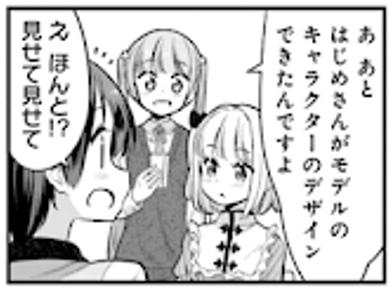

generated caption: 二人の女性が話し合っている様子が映っている
test_dataset\panel001\speech\speech1.PNG
text: ああとはじめさんがモデルのキャラクターのデザインできたんですよ
elapsed time: 32.99495244026184
translation: "Oh, and Hajime-san was able to design the character for the model."
test_dataset\panel001\speech\speech2.PNG
text: えほんと！？現せて見せて
elapsed time: 0.7286884784698486
pausing 19.27131152153015s before next api call
translation: "Really!? Show me, let me see it!"
Subdirectory: test_dataset\panel002


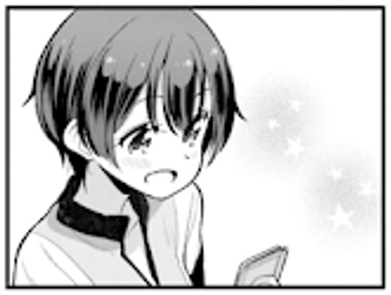

generated caption: 女性が手に持った携帯電話を見ている
Subdirectory: test_dataset\panel003


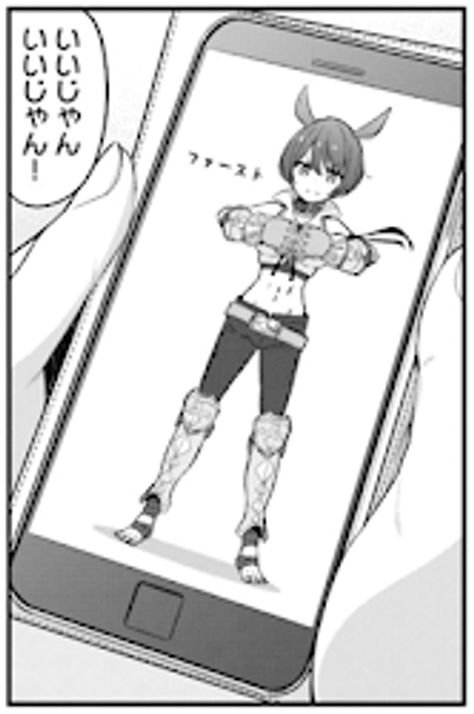

generated caption: 携帯電話を持っているアニメのポスター
test_dataset\panel003\speech\speech1.PNG
text: いいじゃんいいしゃん．．．
elapsed time: 53.30844235420227
translation: "It's fine, it's great to have a cellphone like this... "
Subdirectory: test_dataset\panel004


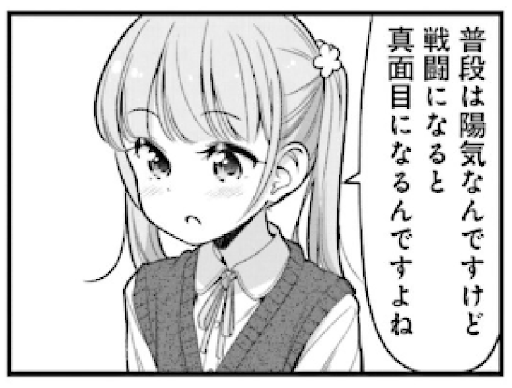

generated caption: ネクタイを締めた髪の長い女性の絵が飾ってある
test_dataset\panel004\speech\speech.png
text: 普段は陽気なんですけど戦闘になると真面目になろうですよね
elapsed time: 31.28185224533081
translation: "In general, I am cheerful, but when it comes to battles, I become serious, don't I?"


In [66]:
translate_manga(manga_directory='test_dataset')

## Useful Function to Create Directory Structure

In [2]:
import os
import math

def create_folders(directory: str, num_of_folders: int, digits: int):
    """
    Create multiple folders within a directory.
    
    Args:
    - directory: The path of the directory where folders will be created.
    - num_of_folders: The number of folders you want to make.
    """
    # Check if the directory exists, if not, create it
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # calculate the number of digits
    num_of_folders_digits = int(math.log10(num_of_folders))+1
    if num_of_folders_digits >= digits:
        digits = num_of_folders_digits
    
    # Create folders
    for i in range(1, num_of_folders + 1):
        # create manga panel folders
        panel_folder_name = f"panel{str(i).zfill(digits)}"
        panel_folder_path = os.path.join(directory, panel_folder_name)
        if not os.path.exists(panel_folder_path):
            os.makedirs(panel_folder_path)
            print(f"Folder '{panel_folder_name}' created successfully.")
        else:
            print(f"Folder '{panel_folder_name}' already exists.")
        
        # create the speech folder paths
        speech_folder_name = "speech"
        speech_folder_path = os.path.join(panel_folder_path, speech_folder_name)
        if not os.path.exists(speech_folder_path):
            os.makedirs(speech_folder_path)
            print(f"Speech folder in '{speech_folder_path}' created successfully.")
        else:
            print(f"Speech folder in '{speech_folder_path}' already exists.")

In [4]:
create_folders(directory="New_Game_Vol_11\Ch119", num_of_folders=60, digits=2)

Folder 'panel01' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel01\speech' created successfully.
Folder 'panel02' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel02\speech' created successfully.
Folder 'panel03' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel03\speech' created successfully.
Folder 'panel04' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel04\speech' created successfully.
Folder 'panel05' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel05\speech' created successfully.
Folder 'panel06' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel06\speech' created successfully.
Folder 'panel07' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel07\speech' created successfully.
Folder 'panel08' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel08\speech' created successfully.
Folder 'panel09' created successfully.
Speech folder in 'New_Gam

# Testing Manga109

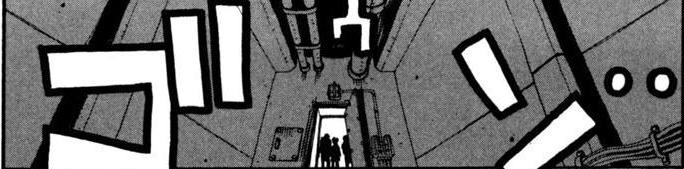

generated caption: 高速道路の映像が流れているように見える
crop panel coords: 898.0, 0.0, 1582.0, 169.0
longer context: 高速道路の映像が流れているように見える。


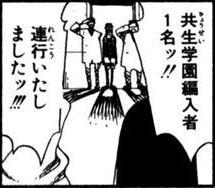

generated caption: 日本のアニメのキャラクターが描かれた看板の前に人が立っている
crop panel coords: 1367.0, 192.0, 1582.0, 380.0
longer context: 高速道路の映像が流れているように見える。日本のアニメのキャラクターが描かれた看板の前に人が立っている。
連行いたしましたッ!!!
waiting 19.999001264572144s before next api call
Helsinki Translation: [{'translation_text': '"We took her away!"'}]
Helsinki Translation w/context: [{'translation_text': 'There\'s a person standing in front of a sign depicting a Japanese cartoon character. "We took him away!"'}]
DeepL Translation: We've brought him in!
DeepL Translation w/context: A person stands in front of a sign with a Japanese anime character. "We have brought him in!
waiting 14.225069522857666s before next api call
ChatGPT translation: "We have taken them into custody!!!"
ChatGPT translation w/context: "I have arrested them!!!"
waiting 20.0s before next api call
ChatGPT translation w/longer context: "We have captured him!!!"
共生学園編入者１名ッ!!
waiting 20.0s before next api call
Helsinki Translation: [{'translation_text': "I'm going to ask you 

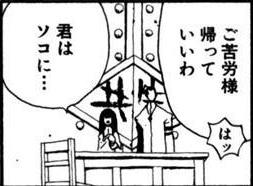

generated caption: 机の上に二人の女性が座っている
crop panel coords: 1101.0, 192.0, 1354.0, 378.0
longer context: 高速道路の映像が流れているように見える。日本のアニメのキャラクターが描かれた看板の前に人が立っている。机の上に二人の女性が座っている。
君はソコに…
waiting 19.998000383377075s before next api call
Helsinki Translation: [{'translation_text': '"You\'re on your own."'}]
Helsinki Translation w/context: [{'translation_text': 'There are two women sitting on the desk.'}]
DeepL Translation: "You're in the..."
DeepL Translation w/context: Two women are sitting on a desk. You are there..."
waiting 14.920223474502563s before next api call
ChatGPT translation: "You stay there…"
ChatGPT translation w/context: "Where are you sitting?"
waiting 20.0s before next api call
ChatGPT translation w/longer context: "You stay there..."
ご苦労様帰っていいわ
waiting 20.0s before next api call
Helsinki Translation: [{'translation_text': 'Thank you so much for coming home.'}]
Helsinki Translation w/context: [{'translation_text': 'There are two women sitting on the desk. "Thank you for coming home.

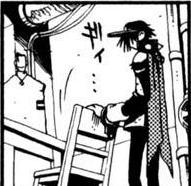

generated caption: 椅子に座っている人の後ろ姿が写っている
crop panel coords: 899.0, 191.0, 1090.0, 377.0
longer context: 日本のアニメのキャラクターが描かれた看板の前に人が立っている。机の上に二人の女性が座っている。椅子に座っている人の後ろ姿が写っている。


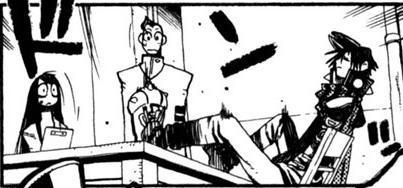

generated caption: 机の上にノートパソコンが置いてある
crop panel coords: 1176.0, 400.0, 1579.0, 588.0
longer context: 机の上に二人の女性が座っている。椅子に座っている人の後ろ姿が写っている。机の上にノートパソコンが置いてある。


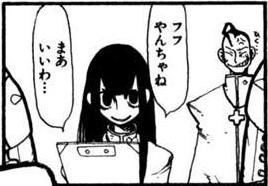

generated caption: 眼鏡をかけた髪の長い女性がこちらを見ている
crop panel coords: 898.0, 402.0, 1166.0, 588.0
longer context: 椅子に座っている人の後ろ姿が写っている。机の上にノートパソコンが置いてある。眼鏡をかけた髪の長い女性がこちらを見ている。
フフやんちゃね
waiting 19.998001098632812s before next api call
Helsinki Translation: [{'translation_text': '"Don\'t be such a fool."'}]
Helsinki Translation w/context: [{'translation_text': 'A woman with long hair on her glasses is looking at me.'}]
DeepL Translation: "Naughty, naughty, naughty."
DeepL Translation w/context: A woman with long hair and glasses is looking at me. "Naughty, naughty."
waiting 15.938322067260742s before next api call
ChatGPT translation: "Hehe, mischievous, aren't you?"
ChatGPT translation w/context: "Hehe, you're quite mischievous, aren't you?"
waiting 20.0s before next api call
ChatGPT translation w/longer context: "Hehe, you're quite mischievous, aren't you?"
まあいいわ…
waiting 20.0s before next api call
Helsinki Translation: [{'translation_text': "It's okay. It's okay. It's okay."}]
Helsinki Translatio

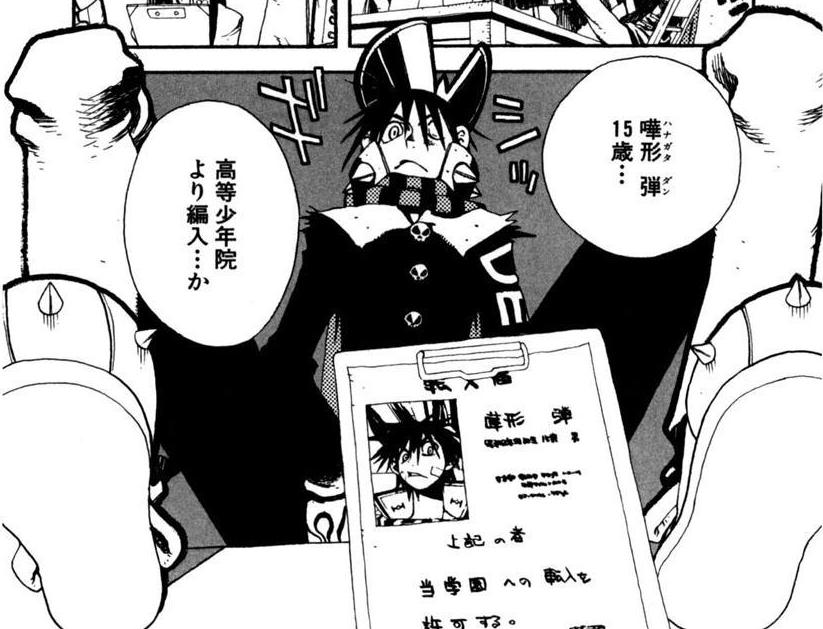

generated caption: アニメのキャラクターが映し出されているモニターの前に座っている人がいる
crop panel coords: 828.0, 540.0, 1651.0, 1169.0
longer context: 机の上にノートパソコンが置いてある。眼鏡をかけた髪の長い女性がこちらを見ている。アニメのキャラクターが映し出されているモニターの前に座っている人がいる。
嘩形 弾
15歳…
waiting 19.99899911880493s before next api call
Helsinki Translation: [{'translation_text': "I'm 15 years old."}]
Helsinki Translation w/context: [{'translation_text': "There's someone sitting in front of the monitor showing the cartoon characters."}]
DeepL Translation: DAN FIGHTING
15 years old..."
DeepL Translation w/context: Someone is sitting in front of a monitor showing an animated character. 'Fighting Dan.
Fifteen years old..."
waiting 16.61662745475769s before next api call
ChatGPT translation: "You're amazing, 15 years old..."
ChatGPT translation w/context: Character's dialogue: "Kagehira Dan, 15 years old..."
waiting 20.0s before next api call
ChatGPT translation w/longer context: "Kagegata Dan, 15 years old..."
高等少年院より編入…か
waiting 20.0s before next api call
Helsinki Transl

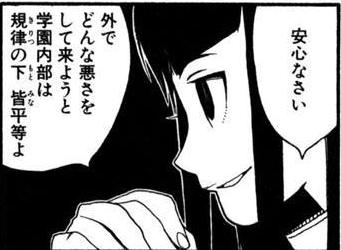

generated caption: 女性がフォークを使ってケーキを食べようとしている
crop panel coords: 409.0, 68.0, 750.0, 318.0
longer context: 眼鏡をかけた髪の長い女性がこちらを見ている。アニメのキャラクターが映し出されているモニターの前に座っている人がいる。女性がフォークを使ってケーキを食べようとしている。
安心なさい
waiting 20.0s before next api call
Helsinki Translation: [{'translation_text': "Don't worry."}]
Helsinki Translation w/context: [{'translation_text': 'A woman is trying to eat a cake with a fork. "Don\'t worry."'}]
DeepL Translation: Rest assured.
DeepL Translation w/context: A woman is trying to eat a cake with a fork. "Don't worry."
waiting 17.225740432739258s before next api call
ChatGPT translation: "Don't worry."
ChatGPT translation w/context: "Don't worry."
waiting 20.0s before next api call
ChatGPT translation w/longer context: "Don't worry."
外でどんな悪きをして来ようと学園内部は規律の下皆平等よ
waiting 20.0s before next api call
Helsinki Translation: [{'translation_text': '"No matter what evil you\'ve done out there, we\'re all equal within the school."'}]
Helsinki Translation w/context: [{'translation_text': 'A

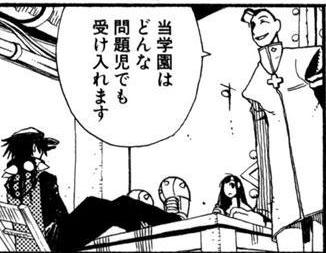

generated caption: 右下の人は座っていて、左の人は立っている
crop panel coords: 72.0, 66.0, 398.0, 319.0
longer context: アニメのキャラクターが映し出されているモニターの前に座っている人がいる。女性がフォークを使ってケーキを食べようとしている。右下の人は座っていて、左の人は立っている。
当学園はどんな問題児でも受け入れます
waiting 19.99899959564209s before next api call
Helsinki Translation: [{'translation_text': '"This school will accept any problem child."'}]
Helsinki Translation w/context: [{'translation_text': 'The person on the right is sitting, and the person on the left is standing.'}]
DeepL Translation: The school accepts any child, no matter how troubled."
DeepL Translation w/context: The person on the lower right is sitting and the person on the left is standing. 'Our school accepts any problem child.'
waiting 15.032495498657227s before next api call
ChatGPT translation: "This school will accept any troublemaker."
ChatGPT translation w/context: "The school accepts all kinds of troublesome students."
waiting 20.0s before next api call
ChatGPT translation w/longer context: "This school accepts any 

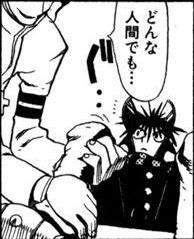

generated caption: アニメのキャラクターのお面をつけている男性
crop panel coords: 552.0, 345.0, 746.0, 584.0
longer context: 女性がフォークを使ってケーキを食べようとしている。右下の人は座っていて、左の人は立っている。アニメのキャラクターのお面をつけている男性。
どんな人聞でも…
waiting 19.998000383377075s before next api call
Helsinki Translation: [{'translation_text': '"No matter what person you\'re listening to..."'}]
Helsinki Translation w/context: [{'translation_text': "The man who's wearing the face of the cartoon character."}]
DeepL Translation: "Anybody who listens..."
DeepL Translation w/context: A man wearing a mask of a cartoon character. "Any man who hears..."
waiting 16.88547396659851s before next api call
ChatGPT translation: No matter what people say...
ChatGPT translation w/context: "No matter who asks me..."
waiting 20.0s before next api call
ChatGPT translation w/longer context: "どんな人に聞いても..."


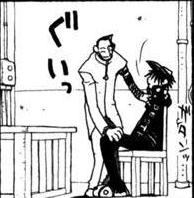

generated caption: 椅子に座っている人と床に座っている人が描かれている
crop panel coords: 553.0, 611.0, 747.0, 809.0
longer context: 右下の人は座っていて、左の人は立っている。アニメのキャラクターのお面をつけている男性。椅子に座っている人と床に座っている人が描かれている。


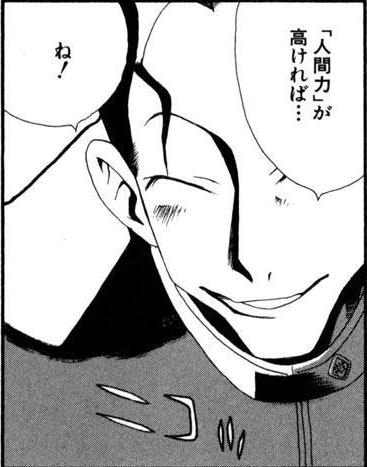

generated caption: あごひげの生えた男性が笑っている
crop panel coords: 173.0, 344.0, 540.0, 811.0
longer context: アニメのキャラクターのお面をつけている男性。椅子に座っている人と床に座っている人が描かれている。あごひげの生えた男性が笑っている。
ね！
waiting 19.99700117111206s before next api call
Helsinki Translation: [{'translation_text': '"What\'s wrong with you?" "What\'s wrong with you?" "What\'s wrong with you?" "What\'s wrong with you?" "What\'s wrong with you?"'}]
Helsinki Translation w/context: [{'translation_text': 'A man with a beard is laughing.'}]
DeepL Translation: Hey!"
DeepL Translation w/context: A man with a goatee is laughing. Hey!"
waiting 15.249533414840698s before next api call
ChatGPT translation: "Ne!" 

This is a casual expression in Japanese used to get someone's attention or to seek agreement or confirmation. It can roughly translate to "hey!" or "right?" in English.
ChatGPT translation w/context: "Hey!"
waiting 20.0s before next api call
ChatGPT translation w/longer context: "Hey!"
「人聞力」が高けれぱ…
waiting 20.0s before next api call
Helsinki Tra

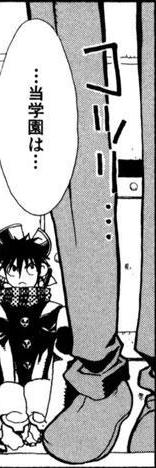

generated caption: 人間の脚に絵がかかれていて、その下に犬がいる
crop panel coords: 6.0, 344.0, 162.0, 812.0
longer context: 椅子に座っている人と床に座っている人が描かれている。あごひげの生えた男性が笑っている。人間の脚に絵がかかれていて、その下に犬がいる。
…当学園は…
waiting 19.998000383377075s before next api call
Helsinki Translation: [{'translation_text': '"It\'s... it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school, it\'s a school.'}]
Helsinki Translation w/context: [{'translation_text': "There's a picture on the human leg, and there's a dog under it."}]
DeepL Translation: "...our academy.

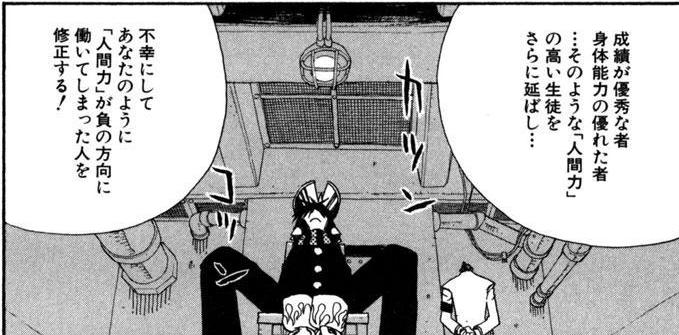

generated caption: 座っているスーツ姿の人の足下に猫がいる
crop panel coords: 64.0, 834.0, 743.0, 1169.0
longer context: あごひげの生えた男性が笑っている。人間の脚に絵がかかれていて、その下に犬がいる。座っているスーツ姿の人の足下に猫がいる。
不宰にしてあなたのように「人間力」が負の方向に働いてしまった人を修正する！
waiting 19.998000621795654s before next api call
Helsinki Translation: [{'translation_text': '"I\'m going to try to correct the person whose human power has been working in a negative direction like you."'}]
Helsinki Translation w/context: [{'translation_text': 'There is a cat under the feet of a man in a sitting suit.'}]
DeepL Translation: "I'm going to fix people like you whose 'people skills' have worked in a negative direction!"
DeepL Translation w/context: There is a cat under the feet of a man in a sitting suit. It corrects someone like you whose "people skills" have worked in a negative direction by being "ungrateful!"
waiting 14.947297096252441s before next api call
ChatGPT translation: "I will not allow people like you who have let their 'humanness' work in a negative direction to

TypeError: Object of type TextResult is not JSON serializable

In [6]:
import manga109api
from pprint import pprint
from PIL import Image, ImageDraw
from manga109utils import Book
import order_estimator
import json

# (0) Instantiate a parser with the root directory of Manga109
manga109_root_dir = "Manga109_released_2023_12_07"
p = manga109api.Parser(root_dir=manga109_root_dir)


def draw_rectangle(img, x0, y0, x1, y1, annotation_type):
    assert annotation_type in ["body", "face", "frame", "text"]
    color = {"body": "#258039", "face": "#f5be41",
             "frame": "#31a9b8", "text": "#cf3721"}[annotation_type]
    draw = ImageDraw.Draw(img)
    draw.rectangle([x0, y0, x1, y1], outline=color, width=10)


book = "GakuenNoise"
page_index = 4
annotation_ordered = p.get_annotation(book=book, separate_by_tag=True)
# pprint(annotation_ordered["page"][page_index])
p = manga109api.Parser(root_dir=manga109_root_dir)
annotation = p.get_annotation(book=book, separate_by_tag=True)
img = Image.open(p.img_path(book=book, index=page_index))
# code to set up the panel order estimator
order_estimator.interception_ratio_threshold = 0.25
book_name = Book(book, manga109_root_dir=manga109_root_dir)

# list of speech bubbles by their id so we dont accidently reread any speech bubbles
read_spch_bbls = []

# list containing the descriptions of the last 3 manga panels
# this will be used later when asking chatgpt to translate with additional context
prior_contexts = []  

# load dictionary of recorded translations, otherwise make a new dictionary
try:
    with open('manga_translations.json', "r", encoding='utf-8') as json_file:
        manga_translations = json.load(json_file)
    print("Successfully loaded translation data!")
except FileNotFoundError:
    print(f"Translation data file not found. Making new translation dictionary.")
    manga_translations = {}
# manga_translations = {}

# heuristic to sort the speech bubbles
def sort_key(spch_bbl):
    return spch_bbl['@ymax'], spch_bbl['@xmax']

# function that sorts all the speech bubbles and reads them in the correct order based on 
# a heuristic of their location on the page. 
def read_text(panel, context, longer_context):
    found_spch_bbls = []  # speech bubbles that are in the panel go here
    speeches_data = []  # a list that holds all the speech translation data. return at the end of function 
    last_completed_api_call_time = time.time()
    api_constraints = 20
    for spch_bbl in annotation_ordered["page"][page_index]['text']:
        # check if the speech bubble is inside the panel
        if ((spch_bbl['@xmax'] <= panel.xmax) and (spch_bbl['@ymax'] <= panel.ymax) and (spch_bbl['@xmax'] >= panel.xmin) and (spch_bbl['@ymax'] >= panel.ymin)) or \
        ((spch_bbl['@xmin'] >= panel.xmin) and (spch_bbl['@ymin'] >= panel.ymin) and (spch_bbl['@xmin'] <= panel.xmax) and (spch_bbl['@ymin'] <= panel.ymax)):
            if spch_bbl['@id'] not in read_spch_bbls:
                read_spch_bbls.append(spch_bbl['@id'])
                found_spch_bbls.append(spch_bbl)
                # print(spch_bbl['#text'])
                # print(f"speech bubble coords: {spch_bbl['@xmin']}, {spch_bbl['@ymin']}, {spch_bbl['@xmax']}, {spch_bbl['@ymax']}")
    
    # sort speech bubbles based on heuristic 
    sorted_spch_bbls = sorted(found_spch_bbls, key=sort_key)
    for spch_bbl in sorted_spch_bbls:
        
        # set up data to be recorded
        speech_data = {"jp_text":spch_bbl['#text'],
                       "context":context,
                       "long_context":longer_context,
                       "Helsinki":"",
                       "Helsinki_cntx":"",
                       "DeepL":"",
                       "DeepL_cntx":"",
                       "ChatGPT":"",
                       "ChatGPT_cntx":"",
                       "ChatGPT_lgcntx":""}
        
        print(spch_bbl['#text'])
        
        # check if we're within our time constraints
        current_time = time.time()
        elapsed_time = current_time - last_completed_api_call_time
        if elapsed_time <= api_constraints:
            print(f"waiting {api_constraints-elapsed_time}s before next api call")
            time.sleep(api_constraints - elapsed_time)
        # ChatGPT contextless
        prompt = (f"Translate this character's dialogue: 「{spch_bbl['#text']}」")        
        chatgpt_trns = get_completion(prompt)
        # update the last completed api call time
        last_completed_api_call_time = time.time()
        
        # Helsinki Translation
        hlsk_trns = translator(f"「{spch_bbl['#text']}」")
        print(f"Helsinki Translation: {hlsk_trns}")
        hlsk_trns_cntx = translator(f"{context}。「{spch_bbl['#text']}」")
        print(f"Helsinki Translation w/context: {hlsk_trns_cntx}")
        
        # DeepL Translation
        dpl_trns = deepl_translate(f"「{spch_bbl['#text']}」")
        print(f"DeepL Translation: {dpl_trns}")
        dpl_trns_cntx = deepl_translate(f"{context}。「{spch_bbl['#text']}」")
        print(f"DeepL Translation w/context: {dpl_trns_cntx}")
        
        # check if we're within our api constraints
        current_time = time.time()
        elapsed_time = current_time - last_completed_api_call_time
        if elapsed_time <= api_constraints:
            print(f"waiting {api_constraints-elapsed_time}s before next api call")
            time.sleep(api_constraints - elapsed_time)
        # ChatGPT w/ 1 panel context
        prompt = (f"Here is the context of a manga panel: {context}." 
                  f"Translate this character's dialogue with this context in mind: 「{spch_bbl['#text']}」")        
        chatgpt_trns_cntx = get_completion(prompt)
        print(f"ChatGPT translation: {chatgpt_trns}")
        print(f"ChatGPT translation w/context: {chatgpt_trns_cntx}")
        last_completed_api_call_time = time.time()
        
        # check if we're within our api constraints
        current_time = time.time()
        elapsed_time = current_time - last_completed_api_call_time
        if elapsed_time <= api_constraints:
            print(f"waiting {api_constraints-elapsed_time}s before next api call")
            time.sleep(api_constraints - elapsed_time)
        # ChatGPT w/ longer context
        prompt = (f"Here is the context of a manga panel: {longer_context}." 
                  f"Translate this character's dialogue with these contexts in mind: 「{spch_bbl['#text']}」")        
        chatgpt_trns_long_cntx = get_completion(prompt)
        print(f"ChatGPT translation w/longer context: {chatgpt_trns_long_cntx}")
        last_completed_api_call_time = time.time()
        # print(f"speech bubble coords: {spch_bbl['@xmin']}, {spch_bbl['@ymin']}, {spch_bbl['@xmax']}, {spch_bbl['@ymax']}")
        
        # record translations
        speech_data["Helsinki"] = hlsk_trns
        speech_data["Helsinki_cntx"] = hlsk_trns_cntx
        speech_data["DeepL"] = dpl_trns
        speech_data["DeepL_cntx"] = dpl_trns_cntx
        speech_data["ChatGPT"] = chatgpt_trns
        speech_data["ChatGPT_cntx"] = chatgpt_trns_cntx
        speech_data["ChatGPT_lgcntx"] = chatgpt_trns_long_cntx
        speeches_data.append(speech_data)
        
    return speeches_data
        

for i_page, page in enumerate(book_name.get_page_iter()):
    if i_page != page_index:
        continue
    pagewidth = img.size[0]
    panels = page.get_bbs()["frame"]
    initial_cut = "two-page"
    boxOrderEstimator = order_estimator.BoxOrderEstimator(
        panels,
        pagewidth=pagewidth,
        initial_cut_option=initial_cut)

    # record data into dictionary
    # key = manga_name and page number/index
    # value = a list of all the panels in order within that page
    manga_translations[f"{book}_pg{i_page}"] = []
    
    for i_panel, panel in enumerate(boxOrderEstimator.ordered_bbs):
        order = i_panel + 1
        if len(panel.panels) == 1:
            # First we need to crop the panel out of the page using the coords provided by manga109 corpus
            # Once we save the cropped panel, we can then turn it into a dataset to later get a caption from
            # show_panel(panel, labeltext=f"{order}", edgecolor="red")
            cropped_panel = img.crop((panel.xmin, panel.ymin, panel.xmax, panel.ymax))
            cropped_panel.save(f"test_content/out.jpg")
            caption_generation_dataset = SampleDataset(f'test_content', visual_encoder['eval'])
            # optional: we can display the cropped panel for testing purposes 
            display(caption_generation_dataset[0]['raw'])
            
            # set up a dictionary to record the data and add it to manga_translations dictionary later
            panel_info = {"panel_id":panel['@id'],
                          "panel_xmin":panel.xmin,
                          "panel_ymin":panel.ymin,
                          "panel_xmax":panel.xmax,
                          "panel_ymax":panel.ymax,
                          "speeches":[]
                          }
            
            # The caption_model.generate method returns the caption within a list as a string with spaces
            # to get the raw caption, we get the 0th item of the list and strip out the spaces with .replace(' ', '')
            gen_caption = caption_model.generate(caption_generation_dataset[0])[0].replace(' ', '')
            print(f"generated caption: {gen_caption}")
            print(f"crop panel coords: {panel.xmin}, {panel.ymin}, {panel.xmax}, {panel.ymax}")
            
            # add generated caption to list of prior contexts
            prior_contexts.append(gen_caption)
            if len(prior_contexts) > 3:
                prior_contexts.pop(0)
            longer_context = ""
            for cntx in prior_contexts:
                longer_context += f"{cntx}。" 
            print(f"longer context: {longer_context}")
            
            # read the text and translate it. after that record the translations
            panel_info['speeches'] = read_text(panel, context=gen_caption, longer_context=longer_context)
            
            # record panel info
            manga_translations[f"{book}_pg{i_page}"].append(panel_info)

        else:
            print("looking at subpanels")
            for subpanel in panel.panels:
                # show_panel(subpanel, edgecolor="orange", linestyle="dotted", labeltext=f"({order})")
                cropped_panel = img.crop((subpanel.xmin, subpanel.ymin, subpanel.xmax, subpanel.ymax))
                cropped_panel.save(f"test_content/out.jpg")
                caption_generation_dataset = SampleDataset(f'test_content', visual_encoder['eval'])
                display(caption_generation_dataset[0]['raw'])
                
                # set up a dictionary to record the data and add it to manga_translations dictionary
                panel_info = {"panel_id":panel['@id'],
                            "panel_xmin":panel.xmin,
                            "panel_ymin":panel.ymin,
                            "panel_xmax":panel.xmax,
                            "panel_ymax":panel.ymax,
                            "speeches":[]
                            }
                
                # The caption_model.generate method returns the caption within a list as a string with spaces
                # to get the raw caption, we get the 0th item of the list and strip out the spaces with .replace(' ', '')
                gen_caption = caption_model.generate(caption_generation_dataset[0])[0].replace(' ', '')
                print(f"generated caption: {gen_caption}")
                print(f"crop panel coords: {subpanel.xmin}, {subpanel.ymin}, {subpanel.xmax}, {subpanel.ymax}")
                # add generated caption to list of prior contexts
                prior_contexts.append(gen_caption)
                if len(prior_contexts) > 3:
                    prior_contexts.pop(0)
                longer_context = ""
                for cntx in prior_contexts:
                    longer_context += f"{cntx}。" 
                print(f"longer context: {longer_context}")
                
                # read the text and translate it. after that record the translations
                panel_info['speeches'] = read_text(panel, context=gen_caption, longer_context=longer_context)
                
                # record panel info
                manga_translations[f"{book}_pg{i_page}"].append(panel_info)    

# for annotation_type in ["body", "face", "frame", "text"]:
# for annotation_type in ["frame"]:
#     rois = sorted(annotation["page"][page_index][annotation_type], key=lambda x: (x["@xmax"], x["@ymin"]))
#     for i, roi in enumerate(rois):
#         # draw_rectangle(img, roi["@xmin"], roi["@ymin"], roi["@xmax"], roi["@ymax"], annotation_type)
#         cropped_panel = img.crop((roi["@xmin"], roi["@ymin"], roi["@xmax"], roi["@ymax"]))
#         cropped_panel.save(f"test_content/out{i}.jpg")
#         text = annotation["page"][page_index]["text"][i]['#text']
#         print(f"out{i}.jpg: {text}")

img.save("out.jpg")

pprint(manga_translations)

with open('manga_translations.json', "w", encoding='utf-8') as json_file:
    json.dump(manga_translations, json_file, ensure_ascii=False)


In [7]:
try:
    with open('manga_translations.json', "r") as json_file:
        manga_translations = json.load(json_file)
    print("Successfully loaded translation data!")
except FileNotFoundError:
    print(f"Translation data file not found. Making new translation dictionary.")
    manga_translations = {}

pprint(manga_translations)

UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 290: character maps to <undefined>

# Leftover Code from Testing

In [1]:
caption_generation_dataset = SampleDataset('./test_content', visual_encoder['eval'])
test_panel = "./test_content/mangapanel.png"

gen_caption = caption_model.generate(caption_generation_dataset[0])[0].replace(' ', '')
print(f"generated caption: {gen_caption}")
print(f"translated caption: {translator(gen_caption)}")
# normal panel
text = mocr(test_panel)
print(f"uncropped text: {text}")

trns_text = translator(text, max_length=max_len_limit)
print(f"trns_uncroptext{trns_text}")

# cropped panel
croptext = mocr("./test_content/mangapanelcrop.png")
print(f"normal_text: {croptext}")

final_text = gen_caption + "。" + croptext[:-1]

trns_croptext = translator(croptext, max_length=max_len_limit)
print(f"trns_croptext: {trns_croptext}")

print(f"final translated text: {translator(final_text, max_length=max_len_limit)}")

final_text_cont = "場面： "+ gen_caption + "。" + "登場人物の言ったこと： 「" + croptext[:-1] + "」"
print(f"finaler translated text: {translator(final_text_cont, max_length=max_len_limit)}")


NameError: name 'SampleDataset' is not defined

In [10]:
prompt = f"Translate this text to english: {final_text_cont}"
response = get_completion(prompt)
print(f"chatgpt translation: {response}")
time.sleep(api_constraints)

prompt = f"Translate this text to english: {final_text}"
response = get_completion(prompt)
print(f"chatgpt 2nd translation: {response}")
time.sleep(api_constraints)

prompt = f"Here is the context of the scene of a manga panel: {gen_caption} And here is something that the character from that same manga panel said: {croptext} \nplease translate the character's words with this context in mind."
response = get_completion(prompt)
print(f"chatgpt 3rd translation: {response}")
time.sleep(api_constraints)

NameError: name 'final_text_cont' is not defined

In [36]:
gen_caption = "女性たちは登場人物の性格について読んで説明している。"
prompt = f"Here is the context of the scene of a manga panel: {gen_caption} And here is something that the girl from that same manga panel said about the character: {croptext} \nplease translate the character's words with this context in mind."
response = get_completion(prompt)
print(f"chatgpt 4th translation: {response}")
time.sleep(api_constraints)

chatgpt 4th translation: The girl from the manga panel said, "Normally, he's cheerful, but when it comes to battles, he becomes serious, right?"
